# Day 2 - Orchestration and data management

In this hands-on we will play with the concepts of orchestration and with the fundamentals of data management.
In particular, you will learn:
 * how to configure `docker-compose` to let multiple container to coordinate to a specific task
 * how to use the HTTP protocol to transfer data files from and to a server
 * how to use NATS to share messages among multiple containers 

## Orchestration (`docker-compose`) - The fundamentals

Yesterday we have seen how to deploy a single application in a container, by running docker commands either in bash or via the Python APIs. 
This approach is very effective if running a single application, but it might become cumbersome to describe the interactions among multiple containers, for example mounting a same volume to two containers to share data (as we have seen in the example of yesterday). 

The coordination of multiple containers goes under the name of *Orchestration* and there are multiple tools to deal with it. 
We will focus on the simplest one, which is [Docker compose](https://docs.docker.com/compose/).

Docker-compose allows to define services in docker containers in a single YAML file, then with a single command you can start, stop, rebuild and inspect your multi-container application.

To start with a very simple example, let's create a docker-compose file with a single docker container, mounting the `python:3.11` image and printing "Hello world!".

In [1]:
%%writefile docker-compose.yaml

services:
  helloworld:
    image: python:3.11
    command:  python3 -c "print('Hello world')"


Overwriting docker-compose.yaml


Then we run the multi-container application (with a single container, but still...) from bash.

If the image `python:3.11` used yesterday is no longer in your local memory, you will see that docker-compose pull the image from DockerHub, then starts the application and you should see it printing something like: 
```
day2-helloworld-1 | Hello world
```


In [2]:
%%bash

docker-compose up

time="2023-10-03T10:22:16Z" level=warning msg="Found orphan containers ([reader]) for this project. If you removed or renamed this service in your compose file, you can run this command with the --remove-orphans flag to clean it up."
 Container writer  Recreate
 Container writer  Recreated


Attaching to day2-helloworld-1
day2-helloworld-1  | Hello world
day2-helloworld-1 exited with code 0


### Your first multi-container application

Now that you know how to deploy a multi-container application, it's time to do it 😆

Let's create a very simple application made of two containers.
The first one writes a file in a shared volume, say `/shared/hw.txt`, the second one waits for 3 seconds (jut to make sure the other is done) and then reads and print the file.

To define the shared volume, we should list the same volume in both the `volumes:` sections of the YAML description of the services. 

The syntax to declare volumes is:
```yaml
volumes:
 - <host_path>:<container_path>[:ro]
```

where:
 - `<host_path>` represents the path of a directory in the host filesystem that you wish to mount inside the container,
 - `<container_path>` represents the path in the container filesystem where you wish to mount the shared volume,
 - `[:ro]` indicates you can optionally append a `:ro` to indicate the volume should be accessed in Read-Only (RO) mode.

For example,
```yaml
volumes:
 - /tmp:/shared
 - ${PWD}:/dev_area:ro 
```
mounts the `/tmp` of the host to be accessible at the mount point `/shared` and mounts the current working directory (in read-only mode) in the `/dev_area` mount point.

Once you know this, you can configure the writer and reader applications, sharing a volume to exchange greetings 🤝

In [3]:
%%writefile docker-compose.yaml

services:
  helloworld:
    image: python:3.11
    command:  python3 -c "print('Hello world', file=open('/shared/hw.txt', 'w'))"
    volumes:
     - /tmp:/shared

  reader:
    image: python:3.11
    command:  python3 -c "import time; time.sleep(3); print (open('/shared/hw.txt', 'r').read())"
    volumes:
     - /tmp:/shared:ro


Overwriting docker-compose.yaml


In [4]:
%%bash

docker-compose up

 Container day2-helloworld-1  Recreate
 Container reader  Recreate
 Container reader  Recreated
 Container day2-helloworld-1  Recreated


Attaching to day2-helloworld-1, day2-reader-1
day2-helloworld-1 exited with code 0
day2-reader-1      | Hello world
day2-reader-1      | 
day2-reader-1 exited with code 0


## Intermezzo - HTTP requests in Python

Before discussing the networking in docker-compose as way of exchange information alternative to sharing volumes, we need to spend a couple of words on the HTTP protocol, as the most standard protocol on the Internet.

The HTTP protocol is a set of rules that governs how data is exchanged on the World Wide Web. 
It allows web browsers and web servers to communicate with each other and transfer hypermedia documents, such as HTML pages, images, videos, and other files. 

The HTTP protocol is based on a client-server model, where the client (usually a web browser) initiates a request 
for a resource and the server responds with a status code and the requested resource or an error message. 

The HTTP protocol also defines various methods, such as `GET`, `POST`, `PUT`, and `DELETE`, that specify the type of action to be performed on the resource. 

In short:
 - `GET`: retrieve data from a web server;
 - `POST`: communicates client-generated data to the web server, which will decide what to do of that data;
 - `PUT`: upload some data at the target url, replacing the existing data;
 - `DELETE`: removes the resource associated to the target url

The HTTP protocol is an application layer protocol in the Internet protocol suite, which means it relies on lower-level protocols, such as TCP/IP, to establish connections and transmit data. 

The HTTP protocol was first developed by Tim Berners-Lee at CERN in 1989 and has evolved over time with several versions and extensions. 
The most widely used versions are HTTP/1.1 and HTTP/2, which offer improved performance, security, and compatibility. 

In Python, the most commonly adopted module for accessing resources via the `http` protocol is `requests` (see the [docs](https://requests.readthedocs.io/en/latest/)).

In [5]:
import requests

Let's make a very simple GET request to see it in action, downloading a file from INFN pandora.

To the purpose of this exercise, I uploaded on INFN pandora a simple text file and I got a public link.

You can see my file by clicking on the link: https://pandora.infn.it/public/30a208/dl/Welcome_to_the_SOSC.txt 

Now, instead of downloading it with your browser, we will download it with `requests`.

Python does not know in advance that that URL corresponds to a file, it might be a web page or some generic data in JSON format.

When you use GET, you obtain a "response object" which has:
 * a three digit ***status code***, that you can interpret as the server providing synthetic information on the status of the elaboration needed to respond to your request, in particular
   * 1xx: I am working on it
   * 2xx: Here you go, allright!
   * 3xx: You should leave now
   * 4xx: I understand your request, but it is somewhat *wrong*
   * 5xx: I made an error while trying to reply
 * ***headers***, providing generic information on the transition
 * ***contents*** (or *data*, or *body*) which is the part really responding your request

Let's see it in action:

In [6]:
## Sends a GET request to the HTTP server of pandora
response = requests.get("https://pandora.infn.it/public/30a208/dl/Welcome_to_the_SOSC.txt")

## The web server replies with a "response object" which has to include a status code. 
## We print the status code and the "reason", which is a short mnemonic text describing the status code
print(f"Status code: {response.status_code} [{response.reason}]")

## We loop on the headers and print them
for k, v in response.headers.items():
    print (k, ":\t", v)

## We print the content (as raw data)
print ("### Contents ###")
print (response.content)


Status code: 200 [OK]
Date :	 Tue, 03 Oct 2023 10:22:38 GMT
Server :	 Apache/2.4.34 (Red Hat) OpenSSL/1.0.2k-fips PHP/7.3.33
X-Powered-By :	 PHP/7.3.33
Connection :	 close
Pragma :	 no-cache
Cache-Control :	 no-cache, must-revalidate
Accept-Ranges :	 bytes
Last-Modified :	 Sat, 23 Sep 2023 13:15:28 GMT
Content-Transfer-Encoding :	 binary
Content-Length :	 20
Content-Range :	 bytes 0-19/20;
Content-Disposition :	 attachment; filename="Welcome_to_the_SOSC.txt"
Expires :	 0
Content-Type :	 application/force-download; name="Welcome_to_the_SOSC.txt"
### Contents ###
b'Welcome to the SOSC!'


Now, if you are sure the content is a text file, you can ask directly for the `text` instead of the raw byte stream:

In [7]:
print (response.text)

Welcome to the SOSC!


### From an HTTP response to a file-like object

Even if we managed to download and visualize the content of the file, we might be interested to access to it as if it was file, but still we don't want to have a real file on the filesystem.
The content we obtained from the response should remain in RAM, but we wish to have the same handles as for a real file to deal with it.

To this purpose, Python introduces the module [`io`](https://docs.python.org/3/library/io.html) and in particular:
 * [`the object io.StringIO`](https://docs.python.org/3/library/io.html#io.StringIO) for text files
 * [`the object io.BytesIO`](https://docs.python.org/3/library/io.html#io.StringIO) for binary files

Let's see `io.StreamIO` in action.

In [8]:
from io import StringIO
## Convert the text of the response to an in-memory text file object
content_file = StringIO(response.text)

## Reads from the in-memory file object the stream and print it
print (content_file.read())

Welcome to the SOSC!


The utlity of this approach might be more evident with binary files, though. 

Let's download the image of the *Infiorata di Spello* we have used for the exercise yesterday.

Status code: 200 [OK]
Date :	 Tue, 03 Oct 2023 10:22:38 GMT
Server :	 Apache/2.4.34 (Red Hat) OpenSSL/1.0.2k-fips PHP/7.3.33
X-Powered-By :	 PHP/7.3.33
Connection :	 close
Pragma :	 no-cache
Cache-Control :	 no-cache, must-revalidate
Accept-Ranges :	 bytes
Last-Modified :	 Mon, 11 Sep 2023 13:58:54 GMT
Content-Transfer-Encoding :	 binary
Content-Length :	 125090
Content-Range :	 bytes 0-125089/125090;
Content-Disposition :	 attachment; filename="italy-infiorata-flower-carpet-festivals.jpg"
Expires :	 0
Content-Type :	 application/force-download; name="italy-infiorata-flower-carpet-festivals.jpg"
### Contents ###
b'\xff\xd8\xff\xe0\x00\x10JFIF'


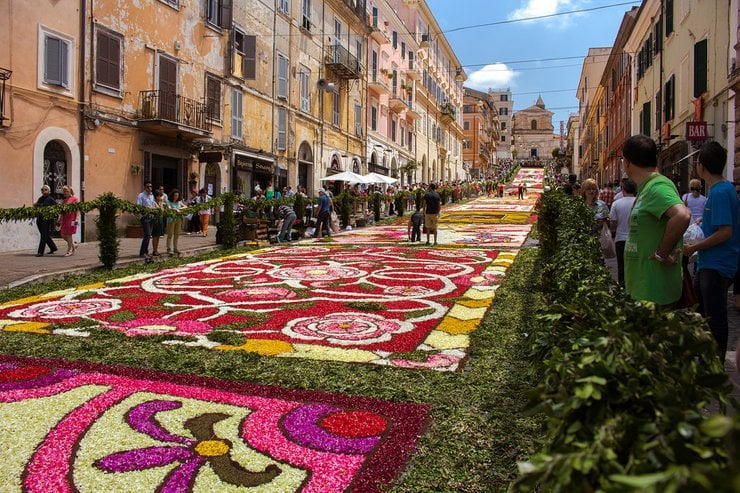

In [9]:
## Make an HTTP request
response = requests.get("https://pandora.infn.it/public/1171b3/dl/italy-infiorata-flower-carpet-festivals.jpg")

## Print the status code and the reason
print(f"Status code: {response.status_code} [{response.reason}]")

## Print the headers
for k, v in response.headers.items():
    print (k, ":\t", v)

## Prints the first 10 bytes of the content (it's binary, don't expect to understand them by eye...)
print ("### Contents ###")
print (response.content[:10])

## Convert the content into an in-memory binary file
from io import BytesIO
figure = BytesIO(response.content)

## and finally loads that in-memory binary file as an image using pillow
from PIL import Image
Image.open(figure)

## Sharing data on the Docker network 

<DIV style='background-color: red; font-size: +2; padding: 5pt; font-weight: bold; color: black;'>
    WARNING!<BR>
    We are now entering the Data Management part of the school. <BR/><BR/>
    There are few rules you MUST follow when you manage data in a network for real applications.
    <UL>
        <LI>Do not manage data.</LI>
        <LI>If you really need to manage data, make them public: public data do not require authN/Z and cannot leak.</LI>
        <LI>If you really need to manage private data, do not do data management yourself; rely on managed tools instead.</LI>
        <LI>If you really need custom data management, make sure you are not managing personal data.</LI>
    </UL>
    <BR/>
    Data management has legal implications concerning security that are not covered in this school. 
    <BR/>
    We are showing you how to deploy services (with many shortcuts) to better understand how they work, not to encourage you to deploy your own.
</DIV>


Now that we have a way to read files from the network (and we anticipated we can use HTTP also to write files with PUT)

Let's rewrite the example above, without sharing a volume, but transferring the file `hw.txt` from one docker to another using HTTP.

There are several new things happening in this short example, so pay attention!

Since the reader will need to use the request module which is not part of the Python Standard Libraries, we will need to customize our image.

We are now real guru of customizing Docker images, so writing our `Dockerfile` should be a no-brainer.

This time we will assign a special name, though, we will call it `Dockerfile.requests`.

We will also introduce another trick to pass a python script as an environmental variable and execute it when spawning the container.
This is conceptually the same thing as passing `python3 -c "<script>"` as we did before, but allows for more slighlty readable `docker-compose` files.

In [10]:
%%writefile Dockerfile.requests

FROM python:3.11

RUN pip install requests

## Default command is executing the content of the PYTHON_SCRIPT environmental variable as if it was a script
CMD echo "$PYTHON_SCRIPT" > script.py && python3 script.py

Overwriting Dockerfile.requests


Now, since we are learning `docker-compose`, instead of building the image with `docker` we will build it directly from the `docker-compose.yaml` file.

In addition, we assign `contaner_name`s to our services.

Note how we define the enviornmental variables in the docker container, and in particular how we define the `PYTHON_SCRIPT` variable that the `CMD` defined in the Dockerfile expects. 

The command `CMD` in `Dockerfile` can be overridden by `command` in `docker-compose` and we do that for the writer part where we prefer using bash than python.

The rest is conceptually very similar to what we have seen before, but notice that:
 * in the writer, we are enqueing multiple python commands, the first to write the file, the second to start an HTTP server on port 8000
 * in the reader, we replaced direct access to the file with an http request to `http://writer:8000/hw.txt`. Note that
   * `writer` is the `container_name` of the writer;
   * `:8000` indicates the port you have chosen for the writer when starting the module `http.server`;
   * `/hw.txt` indicates the file resource to access the file generated by the writer.

In [53]:
%%writefile docker-compose.yaml

services:
  helloworld:
    container_name: 'writer'
    image: python:3.11
    ## We overwrite the default command here, to run two bash commands
    command:  /bin/bash -c "echo 'Hello world' > hw.txt; python3 -m http.server 8000"

  reader:
    container_name: 'reader'
    build:
      dockerfile: Dockerfile.requests
    ## Here we use the default command (running PYTHON_SCRIPT), instead
    #command:  python3 -c "import time; time.sleep(3); import requests; print (requests.get('http://writer:8000/hw.txt').text)"
    environment:
      PYTHON_SCRIPT: | 
        import time, requests
        time.sleep(3)
        print (requests.get('http://writer:8000/hw.txt').text)


Overwriting docker-compose.yaml


Then you can run the application. 
Note that now you have a server running. A server is designed to run forever responding to requests, so either you execute it in detached mode or you make it "non-blocking" by adding a `&` at the end of the line.

In [54]:
%%bash 
docker-compose up --build &
sleep 10
docker-compose down


#0 building with "default" instance using docker driver

#1 [reader internal] load build definition from Dockerfile.requests
#1 transferring dockerfile: 262B done
#1 DONE 0.1s

#2 [reader internal] load .dockerignore
#2 transferring context: 2B done
#2 DONE 0.1s

#3 [reader internal] load metadata for docker.io/library/python:3.11
#3 DONE 0.0s

#4 [reader 1/2] FROM docker.io/library/python:3.11
#4 DONE 0.0s

#5 [reader 2/2] RUN pip install requests
#5 CACHED

#6 [reader] exporting to image
#6 exporting layers done
#6 writing image sha256:cb3459021b2040ccb889da737e024b4f7a64b144862af1a765b16e0664e741e1 0.0s done
#6 naming to docker.io/library/day2-reader 0.0s done
#6 DONE 0.0s


 Network day2_default  Creating
 Network day2_default  Created
 Container writer  Creating
 Container reader  Creating
 Container reader  Created
 Container writer  Created


Attaching to reader, writer


writer  | 192.168.80.3 - - [03/Oct/2023 12:34:15] "GET /hw.txt HTTP/1.1" 200 -


reader  | Hello world
reader  | 
reader exited with code 0


 Container reader  Stopping
 Container writer  Stopping
 Container reader  Stopped
 Container reader  Removing
 Container reader  Removed
 Container writer  Stopped
 Container writer  Removing


writer exited with code 0


 Container writer  Removed
 Network day2_default  Removing
 Network day2_default  Removed


#### Exposing ports

Instead of accessing the HTTP server from the `reader` container, you may want to access it from this notebook, or in general from an application running on the host.
To make this possible you need to map the port of the container on a port of the host, exactly as we did above to map volumes.

You can achieve this result using 
```yaml
  ports:
    - <host_port>:<container_port>
```
where the `host_post` represent the port you will connect from the notebook (as `localhost:<host_port>`) while the `container_port` is the port listened by the service, in this case the `http.server`, that you configured to listen on port 8000.

In [13]:
%%writefile docker-compose.yaml

services:
  helloworld:
    container_name: 'writer'
    image: python:3.11
    command:  /bin/bash -c "echo 'Hello world' > hw.txt; python3 -m http.server 8000"
    ports:
     - 8000:8000  # <--- Maps host port 8000 to container port 8000

  reader:
    container_name: 'reader'
    build:
      dockerfile: Dockerfile.requests
    environment:
      PYTHON_SCRIPT: | 
        import time, requests
        time.sleep(3)
        print (requests.get('http://writer:8000/hw.txt').text)


Overwriting docker-compose.yaml


Then you run the docker-compose in *detached* mode (as we have seen yesterday for the single docker)

In [14]:
%%bash
docker-compose up --detach 

 Network day2_default  Creating
 Network day2_default  Created
 Container writer  Creating
 Container reader  Creating
 Container reader  Created
 Container writer  Created
 Container reader  Starting
 Container writer  Starting
 Container reader  Started
 Container writer  Started


And connect, using `requests` to the container.

In [16]:
import time
time.sleep(3)
print(requests.get("http://localhost:8000/hw.txt").text)

Hello world



### Setup and use an HTTP server capable of accepting files (PUT)

Instead of having a server that exposes a file it produces through a HTTP server, a more common pattern is having a third-party serivice (either in the same docker-compose, or as an external service), where the `writer` upload its file, and from which the `reader` download the file.

There are many implementation of HTTP server accepting PUT, usually referred as WebDAV endpoints, here we picked a slightly obsolete one, because it's light and thin and sufficient for demonstration purposes. Using it in a real application would be rather insane, though. 

The selected `bytemark/webdav` tool image (documented [here](https://hub.docker.com/r/bytemark/webdav/tags)) requires setting the username and the password of the unique user setting the environment variables `USERNAME` and `PASSWORD`.

Both the writer and the reader will need to communicate these credentials in the headers of the request.

In particular, the PUT and GET requests will look like:
```python
## PUT
requests.put('http://<server>:<port>/<path>', auth=(username, password), data=content)

## GET
response = requests.get('http://<server>:<port>/<path>', auth=(username, password))
```

As we discussed above in the simplified case of the `http.server`, the `server` name is the `container_name` of the web server, the port is the port of the service *inside the container*, in this case the port 80, the `path` is the path of the file (or, more in general, of the resource).
In PUT request, we should include the data to upload in the file. 

In [21]:
%%writefile docker-compose.yaml

services:
  webserver:
    image: bytemark/webdav
    container_name: 'webdav'
    ports:
     - 8080:80
    environment:
      USERNAME: sosc_participant
      PASSWORD: Perugia2023

  helloworld:
    container_name: 'writer'
    build:
      dockerfile: Dockerfile.requests
    environment:
      PYTHON_SCRIPT: |
        import time, requests
        time.sleep(2)
        requests.put("http://webdav:80/hw.txt", auth=("sosc_participant", "Perugia2023"), data="Hello world!")
    
  reader:
    container_name: 'reader'
    build:
      dockerfile: Dockerfile.requests
    environment:
      PYTHON_SCRIPT: |
        import time, requests
        time.sleep(3)
        print (requests.get("http://webdav:80/hw.txt", auth=("sosc_participant", "Perugia2023")).text)


Overwriting docker-compose.yaml


In [22]:
%%bash
docker-compose up &
sleep 10
docker-compose down

 Network day2_default  Creating
 Network day2_default  Created
 Container 1c8ce4339043_reader  Recreate
 Container 1c8ce4339043_reader  Recreated


Attaching to df71bfc1e10d_writer, reader, webdav


webdav               | Adding password for user sosc_participant
webdav               | AH00558: httpd: Could not reliably determine the server's fully qualified domain name, using 172.24.0.4. Set the 'ServerName' directive globally to suppress this message
webdav               | AH00558: httpd: Could not reliably determine the server's fully qualified domain name, using 172.24.0.4. Set the 'ServerName' directive globally to suppress this message
webdav               | [Tue Oct 03 10:26:25.765561 2023] [mpm_event:notice] [pid 1:tid 139975556959112] AH00489: Apache/2.4.37 (Unix) configured -- resuming normal operations
webdav               | [Tue Oct 03 10:26:25.765653 2023] [core:notice] [pid 1:tid 139975556959112] AH00094: Command line: 'httpd -D FOREGROUND'


webdav               | 172.24.0.3 - sosc_participant [03/Oct/2023:10:26:27 +0000] "PUT /hw.txt HTTP/1.1" 201 179 "-" "python-requests/2.31.0"
webdav               | 172.24.0.2 - sosc_participant [03/Oct/2023:10:26:27 +0000] "GET /hw.txt HTTP/1.1" 200 12 "-" "python-requests/2.31.0"
reader               | Hello world!
df71bfc1e10d_writer exited with code 0


 Container df71bfc1e10d_writer  Stopping
 Container webdav  Stopping
 Container reader  Stopping
 Container df71bfc1e10d_writer  Stopped
 Container df71bfc1e10d_writer  Removing
 Container reader  Stopped
 Container reader  Removing


reader exited with code 0


 Container df71bfc1e10d_writer  Removed
 Container reader  Removed
webdav               | [Tue Oct 03 10:26:30.597973 2023] [mpm_event:notice] [pid 1:tid 139975556959112] AH00491: caught SIGTERM, shutting down
 Container webdav  Stopped
 Container webdav  Removing


webdav exited with code 0


 Container webdav  Removed
 Network day2_default  Removing
 Network day2_default  Removed


## Distributing messages through the containers

You have now a basic understanding of how containers can share files via the network, but how can they communicate?

In the example above, the reader image knows that there is file to be downloaded from the web server from the beginning, it is not requested to download it.

Distributing messages through applications is a task conceptually different from sharing files, but practically it comes to using a third-party service designed to dispatch messages through the network.
For example, in this school we are using [NATS](https://nats.io/), a Cloud Native, Open Source, High performance messaging service.

As we have seen for the HTTP protocol, we have a server for the NATS protocol. 
We will use the official docker image `nats:latest` for running a NATS server in our deployment.

However in this case, as clients, we do not access directly to resources, but we subscribe and publish to subjects. 

Hence, as a difference with respect to HTTP, the client application should deal with the messages in an asynchronus way. It should wait for the message to arrive and react upon relevant requests. 
In Python, this is achieved by defining ***callback functions*** and associating them to specific subjects. 
When a message on a subject is received, a given callback is invoked.

There are two ways of communicating via NATS: **publishing** messages that to not require a response or **requesting** something in a message.

## Publishing

The logic of the communication from Alice to Bob is as follows:
 * Bob subscribe to the topic `greetings`
 * Alice publishes the message `Hey I am connected!` to the subject `greetings`
 * Bob (and any other subscribed) receive the message `Hey I am connected` from Alice.

In Python, you will have:
##### Bob part
```python
from pynats import NATSClient

with NATSClient(<nats-server>) as client:
    client.subscribe("greetings", callback=print)
    client.wait()
```

Note that the callback is a function to be executed upon reception of a message from a given subject.
In this example we will simply print the whole message as is.

##### Alice part
```python
from pynats import NATSClient

with NATSClient(<nats-server>) as client:
    client.publish("greetings", payload="Hey I am connected")
```


## Requesting

The logic of the communication from Alice to Bob is as follows:
 * Bob subscribe to the topic `greetings`
 * Alice sends a request with the message `Hey there, who's connected?` to the subject `greetings`
 * Bob (and any other subscribed) receive the message and respond with `Hey, it's Bob here`.

In Python, you will have:
##### Bob part
```python
from pynats import NATSClient

   
with NATSClient(<nats-server>) as client:
    def callback(msg):
        client.publish(msg.reply, "Hey, it's Bob here")

    client.subscribe("greetings", callback=callback)
    client.wait()
```

Note that the callback is a function to be executed upon reception of a message from a given subject.
In this example we will simply print the whole message as is.

##### Alice part
```python
from pynats import NATSClient

with NATSClient(<nats-server>) as client:
    client.request("greetings", payload="Hey there, who's connected?", callback=print)
```

Let's see a combination of the two in the following example!

As a first thing, we define our Docker image for knowing the [nats-python](https://github.com/Gr1N/nats-python) module (an oversimplified python client for NATS, barely sufficient for learning purpose).
For a more serious implementation (relying on `asyncio` and hence not treated here) you may look at [nats-py](https://github.com/nats-io/nats.py) instead.

We repeat the trick of the `PYTHON_SCRIPT` enviornmental variable which is very useful to describe these interplays.

In [23]:
%%writefile Dockerfile.nats

FROM python:3.11

RUN pip install nats-python

CMD echo "$PYTHON_SCRIPT" > script.py && python3 script.py

Overwriting Dockerfile.nats


Then we create the `docker-compose.yaml` file embedding the two python scripts representing Alice and Bob.

In [87]:
%%writefile docker-compose.yaml

services:
  nats:
   image: nats
   container_name: msgsrv

  bob:
    container_name: Bob
    build:
      dockerfile: Dockerfile.nats
    environment: 
      PYTHON_SCRIPT: |
        import time; time.sleep(2) ## Wait for the message server to start smoothly
        from pynats import NATSClient

        with NATSClient('nats://msgsrv:4222') as client:
            def callback(msg):
                print ("Received message", msg.payload)
                if msg.reply:
                    client.publish(msg.reply, payload="Hey, it's Bob here")
    
            client.subscribe("greetings", callback=callback)
            client.wait(count=2)  ## count=2 only waits for 2 messages, then exits
    

  alice:
    container_name: Alice
    build:
      dockerfile: Dockerfile.nats
    environment: 
      PYTHON_SCRIPT: |
        import time; time.sleep(4) ## Give Bob some time to subscribe before starting
        from pynats import NATSClient
        with NATSClient('nats://msgsrv:4222') as client:
            client.publish("greetings", payload="Hey, I am connected!") ## publish ignore the response
            print (client.request("greetings", payload="Hey there, who's connected?")) ## request waits for a response
        

Overwriting docker-compose.yaml


Then we run in batch mode, but displaying the output to see the effects of the communication.

In [88]:
%%bash
docker-compose up --build &
sleep 20
docker-compose down

#0 building with "default" instance using docker driver

#1 [bob internal] load .dockerignore
#1 transferring context:
#1 transferring context: 2B done
#1 DONE 0.2s

#2 [bob internal] load build definition from Dockerfile.nats
#2 transferring dockerfile: 149B done
#2 DONE 0.2s

#3 [alice internal] load .dockerignore
#3 transferring context: 2B done
#3 DONE 0.2s

#4 [bob internal] load metadata for docker.io/library/python:3.11
#4 DONE 0.0s

#5 [bob 1/2] FROM docker.io/library/python:3.11
#5 DONE 0.0s

#6 [alice internal] load build definition from Dockerfile.nats
#6 transferring dockerfile: 149B done
#6 DONE 0.4s

#4 [alice internal] load metadata for docker.io/library/python:3.11
#4 DONE 0.0s

#5 [alice 1/2] FROM docker.io/library/python:3.11
#5 DONE 0.0s

#7 [alice 2/2] RUN pip install nats-python
#7 CACHED

#8 [alice] exporting to image
#8 exporting layers done
#8 writing image sha256:e9ef54be116e0327f4c94bb7db4afa25a7c89f99ff0cfeed39b95845d0163231 0.1s done
#8 naming to docker.io/l

 Network day2_default  Creating
 Network day2_default  Created
 Container Alice  Creating
 Container msgsrv  Creating
 Container Bob  Creating
 Container Bob  Created
 Container msgsrv  Created
 Container Alice  Created


Attaching to Alice, Bob, msgsrv


msgsrv  | [1] 2023/10/03 13:26:45.091727 [INF] Starting nats-server
msgsrv  | [1] 2023/10/03 13:26:45.091895 [INF]   Version:  2.10.1
msgsrv  | [1] 2023/10/03 13:26:45.091897 [INF]   Git:      [d3ef745]
msgsrv  | [1] 2023/10/03 13:26:45.091899 [INF]   Cluster:  my_cluster
msgsrv  | [1] 2023/10/03 13:26:45.091901 [INF]   Name:     NBFBXEDY7MKWF4OEF27P5KXHOBOCQMEFMCMCYD44S34DIKWKIH2LSKVU
msgsrv  | [1] 2023/10/03 13:26:45.091903 [INF]   ID:       NBFBXEDY7MKWF4OEF27P5KXHOBOCQMEFMCMCYD44S34DIKWKIH2LSKVU
msgsrv  | [1] 2023/10/03 13:26:45.091917 [INF] Using configuration file: nats-server.conf
msgsrv  | [1] 2023/10/03 13:26:45.092761 [INF] Starting http monitor on 0.0.0.0:8222
msgsrv  | [1] 2023/10/03 13:26:45.092962 [INF] Listening for client connections on 0.0.0.0:4222
msgsrv  | [1] 2023/10/03 13:26:45.093095 [INF] Server is ready
msgsrv  | [1] 2023/10/03 13:26:45.093163 [INF] Cluster name is my_cluster
msgsrv  | [1] 2023/10/03 13:26:45.093249 [INF] Listening for route connections on 0.0.0

Bob     | Received message b'Hey, I am connected!'
Bob     | Received message b"Hey there, who's connected?"
Alice   | NATSMessage(sid=0, subject='_INBOX.QOXz77FSVQ48MahnxlN4Ks', reply='', payload=b"Hey, it's Bob here")
Alice exited with code 0
Bob exited with code 0


 Container Alice  Stopping
 Container msgsrv  Stopping
 Container Bob  Stopping
 Container Alice  Stopped
 Container Alice  Removing
 Container Bob  Stopped
 Container Bob  Removing
 Container Bob  Removed
 Container Alice  Removed
msgsrv  | [1] 2023/10/03 13:26:58.412475 [INF] Initiating Shutdown...
msgsrv  | [1] 2023/10/03 13:26:58.412638 [INF] Server Exiting..
 Container msgsrv  Stopped
 Container msgsrv  Removing


msgsrv exited with code 0


 Container msgsrv  Removed
 Network day2_default  Removing
 Network day2_default  Removed


## Structured text data through HTTP and NATS using JSON

Exchanging text messages is undoubtfully useful, but most often we need to share some structured information, suche as lists or dictionaries. 

For this purpose JSON, the *Javascript Serialization Object Notation*, is the standard format to share structured data (such as lists and dictionaries) through the HTTP (and NATS) protocols.

JSON is a snippet of Javascript (and hence a string) defining a data structure. 

Using the Python `json` module (which is part of the Python Standard Libraries) you can serialize to JSON most of the data structures of the Standard Libraries (such as lists, dictionaries...)

You may want to check the [orjson library](https://github.com/ijl/orjson) if you feel sending objects such as numpy arrays via JSON is of relevance to your use-case.


Let's stick to the standard version and let's see how to convert from a dictionary and a list to a string

In [76]:
import json
string_payload = json.dumps({'school': 'SOSC', 'years': [2022, 2023]})
print(type(string_payload), string_payload)

<class 'str'> {"school": "SOSC", "years": [2022, 2023]}


and vice-versa

In [36]:
decoded_payload = json.loads(string_payload)
print(type(decoded_payload), decoded_payload)

<class 'dict'> {'school': 'SOSC', 'years': [2022, 2023]}


Finally, let's rewrite the example above between Alice and Bob, by using structured objects.

In [97]:
%%writefile docker-compose.yaml

services:
  nats:
   image: nats
   container_name: msgsrv

  bob:
    container_name: Bob
    build:
      dockerfile: Dockerfile.nats
    environment: 
      PYTHON_SCRIPT: |
        import time; time.sleep(2) ## Wait for the message server to start smoothly
        from pynats import NATSClient
        import json

        with NATSClient('nats://msgsrv:4222') as client:
            def callback(msg):
                payload = json.loads(msg.payload)
                print ("Received message", payload['content'], 'from', payload['author'])
                if msg.reply:
                    client.publish(msg.reply, payload=json.dumps({
                        'author': 'Bob',
                        'content': "Hey! I'm Bob!"
                    }))
    
            client.subscribe("greetings", callback=callback)
            client.wait(count=2)  ## count=2 only waits for 2 messages, then exits
    

  alice:
    container_name: Alice
    build:
      dockerfile: Dockerfile.nats
    environment: 
      PYTHON_SCRIPT: |
        import time; time.sleep(4) ## Give Bob some time to subscribe before starting
        import json
        from pynats import NATSClient
        with NATSClient('nats://msgsrv:4222') as client:
            client.publish("greetings", payload=json.dumps({
                'author': 'Alice', 
                'content': "Hey, I am connected!"
            }))
            print (client.request("greetings", payload=json.dumps({
                'author': 'Alice',
                'content': "Hey there, who's connected?"
            }))) ## request waits for a response
        

Overwriting docker-compose.yaml


In [98]:
%%bash
docker-compose up --build &
sleep 20
docker-compose down

#0 building with "default" instance using docker driver

#1 [bob internal] load build definition from Dockerfile.nats
#1 transferring dockerfile: 149B done
#1 ...

#2 [alice internal] load build definition from Dockerfile.nats
#2 transferring dockerfile: 149B done
#2 DONE 0.1s

#3 [alice internal] load .dockerignore
#3 transferring context: 2B done
#3 DONE 0.2s

#1 [bob internal] load build definition from Dockerfile.nats
#1 DONE 0.3s

#4 [bob internal] load .dockerignore
#4 transferring context: 2B done
#4 DONE 0.4s

#5 [alice internal] load metadata for docker.io/library/python:3.11
#5 DONE 0.0s

#6 [alice 1/2] FROM docker.io/library/python:3.11
#6 DONE 0.0s

#7 [alice 2/2] RUN pip install nats-python
#7 CACHED

#8 [alice] exporting to image
#8 exporting layers done
#8 writing image sha256:e9ef54be116e0327f4c94bb7db4afa25a7c89f99ff0cfeed39b95845d0163231 0.0s done
#8 naming to docker.io/library/day2-alice
#8 naming to docker.io/library/day2-alice 0.0s done
#8 DONE 0.1s

#6 [bob 1/2] F

 Network day2_default  Creating
 Network day2_default  Created
 Container Bob  Creating
 Container Alice  Creating
 Container msgsrv  Creating
 Container Alice  Created
 Container Bob  Created
 Container msgsrv  Created


Attaching to Alice, Bob, msgsrv


msgsrv  | [1] 2023/10/03 13:42:31.318188 [INF] Starting nats-server
msgsrv  | [1] 2023/10/03 13:42:31.318341 [INF]   Version:  2.10.1
msgsrv  | [1] 2023/10/03 13:42:31.318344 [INF]   Git:      [d3ef745]
msgsrv  | [1] 2023/10/03 13:42:31.318345 [INF]   Cluster:  my_cluster
msgsrv  | [1] 2023/10/03 13:42:31.318347 [INF]   Name:     NDIN45AA3Y2B5PAV2X3KA24OEOPRZCDKP7KL7LUJRGNFQ3I7N7426UKO
msgsrv  | [1] 2023/10/03 13:42:31.318355 [INF]   ID:       NDIN45AA3Y2B5PAV2X3KA24OEOPRZCDKP7KL7LUJRGNFQ3I7N7426UKO
msgsrv  | [1] 2023/10/03 13:42:31.318367 [INF] Using configuration file: nats-server.conf
msgsrv  | [1] 2023/10/03 13:42:31.319287 [INF] Starting http monitor on 0.0.0.0:8222
msgsrv  | [1] 2023/10/03 13:42:31.319370 [INF] Listening for client connections on 0.0.0.0:4222
msgsrv  | [1] 2023/10/03 13:42:31.319501 [INF] Server is ready
msgsrv  | [1] 2023/10/03 13:42:31.319612 [INF] Cluster name is my_cluster
msgsrv  | [1] 2023/10/03 13:42:31.319633 [INF] Listening for route connections on 0.0.0

Bob     | Received message Hey, I am connected! from Alice
Bob     | Received message Hey there, who's connected? from Alice
Alice   | NATSMessage(sid=0, subject='_INBOX.ZmpqFsEExeVpT4q66T893I', reply='', payload=b'{"author": "Bob", "content": "Hey! I\'m Bob!"}')
Alice exited with code 0
Bob exited with code 0


 Container Bob  Stopping
 Container Alice  Stopping
 Container msgsrv  Stopping
 Container Bob  Stopped
 Container Bob  Removing
 Container Alice  Stopped
 Container Alice  Removing
 Container Bob  Removed
 Container Alice  Removed
msgsrv  | [1] 2023/10/03 13:42:46.437022 [INF] Initiating Shutdown...
msgsrv  | [1] 2023/10/03 13:42:46.437169 [INF] Server Exiting..
 Container msgsrv  Stopped
 Container msgsrv  Removing


msgsrv exited with code 0


 Container msgsrv  Removed
 Network day2_default  Removing
 Network day2_default  Removed


## Conclusion

In this hands-on we have discussed orchestration and network-based data management in a multi-container application.

We have seen how to describe applications involving multiple containers, how to transfer data files from one container to another via the HTTP protocol, possibly relying on third-pary applications acting as servers, accepting data files in input and enabling download of the files with the same mechanics one would use to download a public resource online (such as a Web page). 

Finally, we have seen how the approach of having a third-party application providing a service to connect different containers can be extended to messaging using NATS. 
Instead of waiting for requests, the NATS protocol accepts subscriptions to topics and distributes messages through the subscribers. 

Messages are managed asyncronously by the client application, for example implementing the concept of ***callback*** function. 

